# Transition Path Theory applied to triplewell dynamics

Based on: 
Helfmann, L., Ribera Borrell, E., Schütte, C., & Koltai, P. (2020). Extending Transition Path Theory: Periodically-Driven and Finite-Time Dynamics. [arXiv preprint arXiv:2002.07474.](https://arxiv.org/pdf/2002.07474.pdf)  


In [1]:
from pytpt import stationary  
from pytpt import periodic  
from pytpt import finite  
from plotting import plot_3well, \
                     plot_3well_effcurrent, \
                     plot_3well_potential, \
                     plot_3well_vector_field
 
import numpy as np

import os.path

In [2]:
# define directories path to save the data and figures 
my_path = os.path.abspath('')
data_path = os.path.join(my_path, 'data')
file_path = None

#### Load the transition matrices of the triple well that were estimated from sampled data. As sets A and B the two deep wells of the energy landscape are chosen.

In [3]:
# load triple well data
triplewell_construction = np.load(
    os.path.join(data_path, 'triplewell_construction.npz'),
    allow_pickle=True,
)

interval = triplewell_construction['interval']
dx = triplewell_construction['dx']
ind_A = triplewell_construction['ind_A']
ind_B = triplewell_construction['ind_B']
ind_C = triplewell_construction['ind_C']
T = triplewell_construction['T']
T_m = triplewell_construction['T_m']

#state space
x = np.arange(interval[0,0], interval[0,1] + dx, dx) #box centers in x and y direction
y = np.arange(interval[1,0], interval[1,1] + dx, dx)
xv, yv = np.meshgrid(x, y)

xdim = np.shape(xv)[0] #discrete dimension in x and y direction
ydim = np.shape(xv)[1]
dim_st = xdim * ydim # dimension of the statespace
xn = np.reshape(xv, (xdim * ydim, 1))
yn = np.reshape(yv, (xdim * ydim, 1))
grid = np.squeeze(np.array([xn, yn]))

#define AB sets
densAB = np.zeros(dim_st)
densAB[ind_A] = 1
densAB[ind_B] = 1

# Stationary, infinite-time process

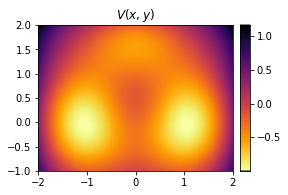

In [4]:
#triple well in 2D energy landscape V and gradient dV
factor = 0.25
V0 = lambda x, y: 1 * factor*(3*np.exp(-x**2-(y-(1./3))**2) \
                - 3*np.exp(-x**2-(y-(5./3))**2) - 5*np.exp(-(x-1)**2-y**2) \
                - 5*np.exp(-(x+1)**2-y**2)  + 0.2*(x**4) + 0.2*(y-1./3)**4)
 

# plot potential and gradient
title = 'Triple well Potential'
subtitles=[
    r'$V(x, y)$', 
]
plot_3well_potential(
    potential=V0,
    title=title,
    file_path=None,
    subtitles=subtitles,
)

In [5]:
# TPT ergodic, infinite-time

# instantiate
well3 = stationary.tpt(T, ind_A, ind_B, ind_C)
# compute statistics
well3.compute_statistics()

stat_dens = well3._stat_dens
q_f = well3._q_f
q_b = well3._q_b
reac_norm_factor = well3._reac_norm_factor
norm_reac_dens = well3._norm_reac_dens
eff_current = well3._eff_current
rate = well3._rate
length = well3._length

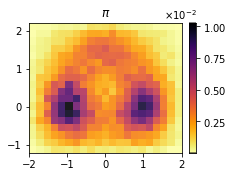

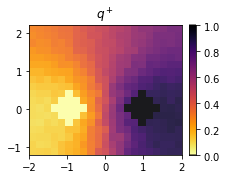

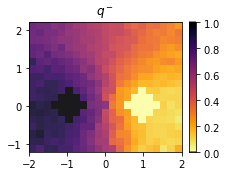

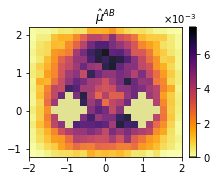

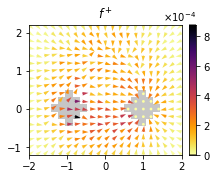

In [6]:
data = np.array([stat_dens])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim, ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), 1, (3*1,3), v_min, v_max, ['$\pi$'], file_path=file_path)

data = np.array([q_f])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0],interval[0,1], interval[1,0], interval[1,1]), 1, (3*1,3), v_min, v_max, ['$q^+$'],  file_path=file_path)

data = np.array([q_b])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0],interval[0,1],interval[1,0],interval[1,1]), 1, (3*1,3), v_min, v_max, ['$q^-$'],  file_path=file_path)

data = np.array([norm_reac_dens])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0],interval[0,1],interval[1,0],interval[1,1]) , 1, (3*1,3), v_min, v_max, ['$\hat{\mu}^{AB}$'],  file_path=file_path, background=densAB)


# calculation the effective vector for each state
eff_vectors = np.zeros((dim_st, 2))
eff_vectors_unit = np.zeros((dim_st, 2))
colors = np.zeros(dim_st)
for i in np.arange(dim_st):
    for j in np.arange(dim_st):
        if np.linalg.norm(np.array([xn[j] - xn[i], yn[j] - yn[i]])) > 0:
            eff_vectors[i,0] += eff_current[i,j] *  (xn[j] - xn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
            eff_vectors[i,1] += eff_current[i,j] *  (yn[j] - yn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
    colors[i] = np.linalg.norm(eff_vectors[i,:])
    if colors[i] > 0:
        eff_vectors_unit[i,:] = eff_vectors[i,:]/colors[i] 
            
plot_3well_effcurrent(np.array([eff_vectors_unit]), np.array([colors]), xn, yn, densAB, (xdim, ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), 1, (3*1, 3), ['$f^+$'],  file_path=file_path)


In [7]:
print("rate (infinite-time, stationary): %f" % rate)
print("mean length (infinite-time, stationary): %f" % length)

rate (infinite-time, stationary): 0.014374
mean length (infinite-time, stationary): 9.858616


# Periodically forced process

In [8]:
# TPT periodic
 
M = 6 # length of period 

def Tm(m): 
    return T_m[np.mod(m, M), :, :].squeeze()

# instantiate
well3_periodic = periodic.tpt(Tm, M, ind_A, ind_B, ind_C)
# compute statistics
well3_periodic.compute_statistics()



stat_dens_p = well3_periodic._stat_dens
q_f_p = well3_periodic._q_f
q_b_p = well3_periodic._q_b
reac_norm_factor_p = well3_periodic._reac_norm_factor
norm_reac_dens_p = well3_periodic._norm_reac_dens
eff_current_p = well3_periodic._eff_current
rate_p = well3_periodic._rate
time_av_rate_p = well3_periodic._time_av_rate
av_length_p = well3_periodic._av_length

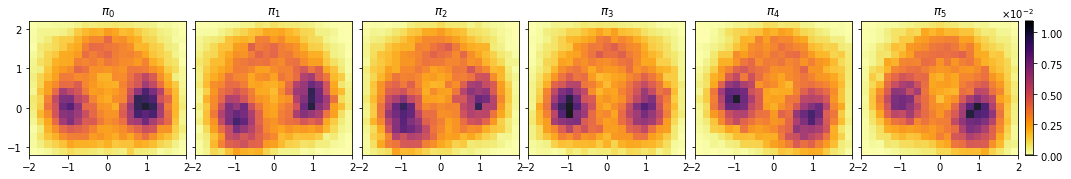

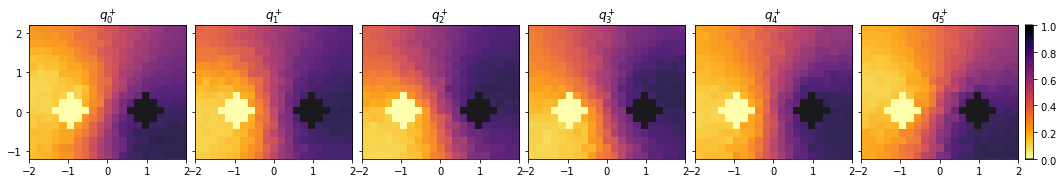

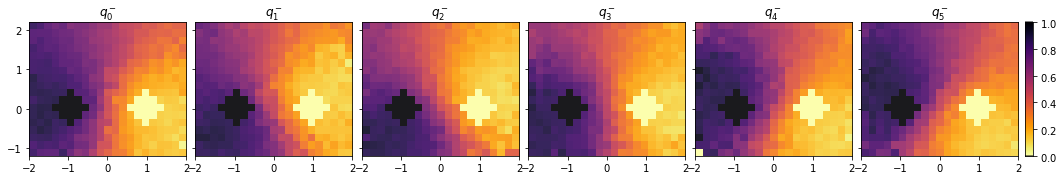

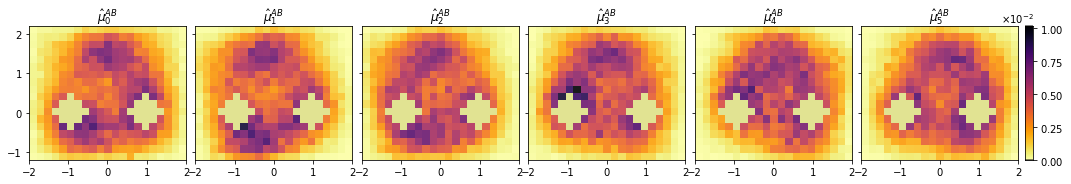

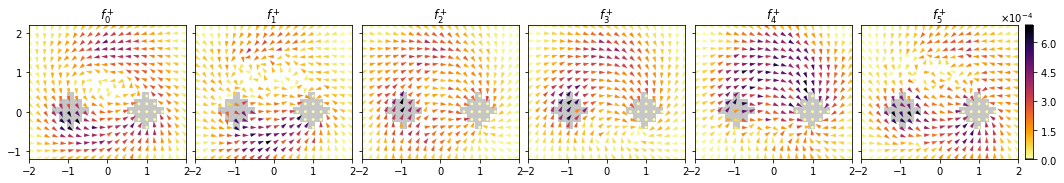

In [9]:

# plots periodic
example_name = 'triplewell_periodic'
M = np.shape(T_m)[0]

def subtitles_m(quant,M):
    return np.array([quant.format(str(i)) for i in np.arange(M)])

data = stat_dens_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max, subtitles_m('$\pi_{}$', M),  file_path=file_path) 

data = q_f_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max, subtitles_m('$q^+_{}$', M), file_path=file_path)

data = q_b_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max, subtitles_m('$q^-_{}$', M), file_path=file_path)

data = norm_reac_dens_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max,np.array(['$\hat{\mu}^{AB}_0$','$\hat{\mu}^{AB}_1$','$\hat{\mu}^{AB}_2$','$\hat{\mu}^{AB}_3$','$\hat{\mu}^{AB}_4$','$\hat{\mu}^{AB}_5$']), file_path=file_path, background=densAB) 


# calculation the effective vector for each state
eff_vectors_p = np.zeros((M, dim_st, 2))
eff_vectors_unit_p = np.zeros((M, dim_st, 2))
colors_p = np.zeros((M, dim_st))
for m in np.arange(M):
    for i in np.arange(dim_st):
        for j in np.arange(dim_st):
            if np.linalg.norm(np.array([xn[j] - xn[i], yn[j] - yn[i]])) > 0:
                eff_vectors_p[m,i,0] += eff_current_p[m,i,j] *  (xn[j] - xn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
                eff_vectors_p[m,i,1] += eff_current_p[m,i,j] *  (yn[j] - yn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
        colors_p[m,i] = np.linalg.norm(eff_vectors_p[m,i,:])
        if colors_p[m,i]>0:
            eff_vectors_unit_p[m,i,:] = eff_vectors_p[m,i,:]/colors_p[m,i]
 

plot_3well_effcurrent(eff_vectors_unit_p, colors_p, xn, yn, densAB, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), subtitles_m('$f^+_{}$', M), file_path=file_path) 
 

In [10]:
print("periodic-averaged rate (infinite-time, periodic): %f" % time_av_rate_p[0])
print("mean length (infinite-time, periodic): %f" % av_length_p)

periodic-averaged rate (infinite-time, periodic): 0.015324
mean length (infinite-time, periodic): 9.685802


# Finite-time process

In [11]:
# TPT finite time, time-homogeneous
 

def Tn(n):  
    return T #T_m[np.mod(m,M),:,:].squeeze()

N = 6 #time window

# initial density
init_dens_well3_finite = well3._stat_dens
# instantiate
well3_finite = finite.tpt(
    Tn,
    N,
    ind_A,
    ind_B,
    ind_C,
    init_dens_well3_finite,
)
# compute statistics
well3_finite.compute_statistics()


dens_f = well3_finite._dens
q_f_f = well3_finite._q_f
q_b_f = well3_finite._q_b
reac_norm_factor_f = well3_finite._reac_norm_factor
norm_reac_dens_f = well3_finite._norm_reac_dens
eff_current_f = well3_finite._eff_current
rate_f = well3_finite._rate
time_av_rate_f = well3_finite._time_av_rate
av_length_f = well3_finite._av_length

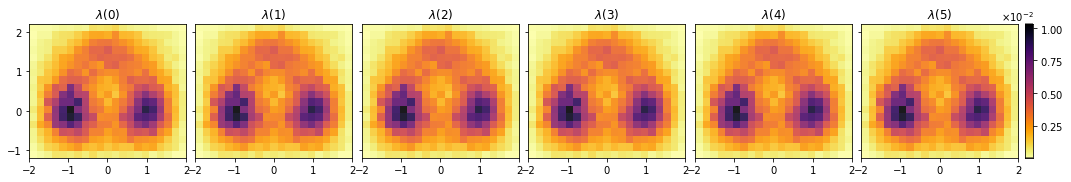

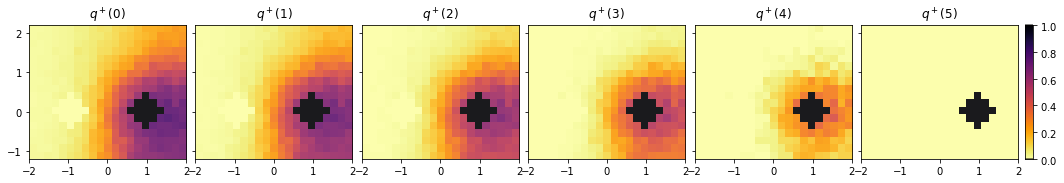

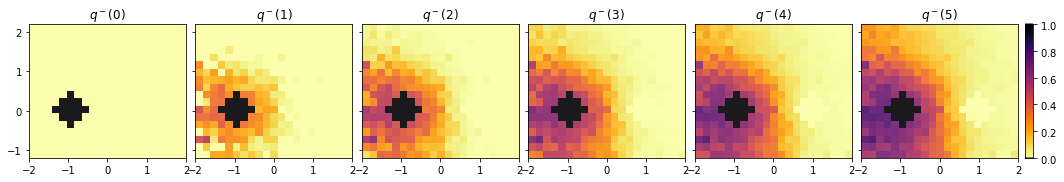

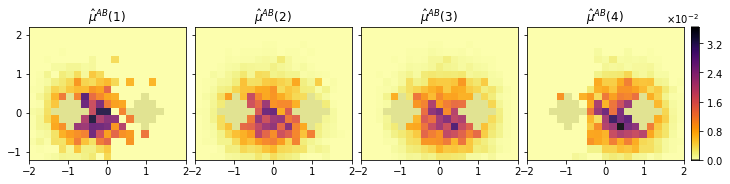

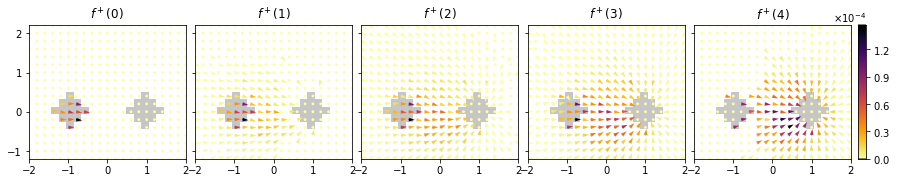

In [12]:


# plots finite-time
example_name = 'triplewell_finite'
N = 6 # time window

data = dens_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N, (3*N,3), v_min, v_max, subtitles_m('$\lambda({})$',N), file_path=file_path)

data = q_f_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N, (3*N,3), v_min, v_max, subtitles_m('$q^+({})$',N), file_path=file_path)

data = q_b_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N, (3*N,3), v_min, v_max, subtitles_m('$q^-({})$',N), file_path=file_path)

data = norm_reac_dens_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data[1:N-1,:], (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N-2, (3*(N-2),3), v_min, v_max, np.array(['$\hat{\mu}^{AB}(1)$','$\hat{\mu}^{AB}(2)$','$\hat{\mu}^{AB}(3)$','$\hat{\mu}^{AB}(4)$']), file_path=file_path, background=densAB) 

# calculation the effective vector for each state
eff_vectors_f = np.zeros((N,dim_st, 2))
eff_vectors_unit_f = np.zeros((N,dim_st, 2))
colors_f = np.zeros((N,dim_st))
for n in np.arange(N):
    for i in np.arange(dim_st):
        for j in np.arange(dim_st):
            # if np.isnan(eff_current_f[n,i,j])==False:

            if np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))>0:
                eff_vectors_f[n,i,0] += eff_current_f[n,i,j] *  (xn[j] - xn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
                eff_vectors_f[n,i,1] += eff_current_f[n,i,j] *  (yn[j] - yn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
        colors_f[n,i] = np.linalg.norm(eff_vectors_f[n,i,:])
        if colors_f[n,i]>0:
            eff_vectors_unit_f[n,i,:] = eff_vectors_f[n,i,:]/colors_f[n,i]
            

plot_3well_effcurrent(eff_vectors_unit_f[:N-1,:,:], colors_f[:N-1,:], xn, yn, densAB,(xdim,ydim), (interval[0,0],interval[0,1],interval[1,0],interval[1,1]), N-1, (3*(N-1),3), subtitles_m('$f^+({})$',N-1), file_path=file_path)
 

In [13]:
print("time-averaged rate (finite-time, time-homogeneous): %f" % time_av_rate_f[0])
print("mean length (finite-time, time-homogeneous): %f" % av_length_f)

time-averaged rate (finite-time, time-homogeneous): 0.001911
mean length (finite-time, time-homogeneous): 1.860586
